In [1]:
from google.colab import drive
from keras import backend as K
from keras import optimizers, regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D, GaussianDropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import img_to_array
from tqdm import tqdm
from zipfile import ZipFile
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
base_dir = "/blindness-detection/data/"

In [11]:
dataset = []
labels = []


def preprocess_img(label,path):
  img = cv2.imread(path,cv2.IMREAD_COLOR)
  img_array = img_to_array(img)
  img_array = img_array/255
  dataset.append(img_array)
  labels.append(str(label))


def preprocess_data():
  train_data = pd.read_csv(base_dir +"/train.csv")
  train_data.head()

  id_code_data = train_data['id_code']
  diagnosis_data = train_data['diagnosis']

  for id_code,diagnosis in tqdm(zip(id_code_data,diagnosis_data)):
    path = os.path.join(base_dir+'train','{}.png'.format(id_code))
    preprocess_img(diagnosis,path)
    
  id_code_data = train_data['id_code']
  diagnosis_data = train_data['diagnosis']

  images = np.array(dataset)
  label_arr = np.array(labels)

  x_train,x_test,y_train,y_test = train_test_split(images,label_arr,test_size=0.20,random_state=42)

  y_train = np_utils.to_categorical(y_train, num_classes=5)
  y_test = np_utils.to_categorical(y_test, num_classes=5)

  return x_train, x_test, y_train, y_test

In [12]:
x_train, x_test, y_train, y_test = preprocess_data()

3662it [00:08, 424.41it/s]


In [ ]:
def build_cnn():

  model = Sequential()
  model.add(Conv2D(16, (3, 3), input_shape=(50,50,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(5, activation='softmax'))
  
  return model

model = build_cnn()
model.summary()

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint("cnn.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
hist = model.fit(x_train,y_train,batch_size=32,epochs=50, validation_data=(x_test, y_test), callbacks=[checkpoint, early])

Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 2.7062 - accuracy: 0.5930
Epoch 1: val_accuracy improved from -inf to 0.71214, saving model to cnn.h5
92/92 [==============================] - 11s 111ms/step - loss: 2.7062 - accuracy: 0.5930 - val_loss: 0.9969 - val_accuracy: 0.7121
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.6955
Epoch 2: val_accuracy did not improve from 0.71214
92/92 [==============================] - 10s 104ms/step - loss: 0.9237 - accuracy: 0.6955 - val_loss: 0.9075 - val_accuracy: 0.7067
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.7002
Epoch 3: val_accuracy did not improve from 0.71214
92/92 [==============================] - 10s 105ms/step - loss: 0.8719 - accuracy: 0.7002 - val_loss: 0.8942 - val_accuracy: 0.6862
Epoch 4/50
92/92 [==============================] - ETA: 0s - loss: 0.8310 - accuracy: 0.7129
Epoch 4: val_accuracy improved from 0.71214 to 0.7

In [37]:
pred = model.predict(x_test)
score = round(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print("Accuracy: ", score*100,"%")

23/23 [==============================] - 1s 28ms/step
Accuracy:  74.0 %


In [38]:
report = classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       351
           1       0.45      0.32      0.38        68
           2       0.60      0.83      0.70       213
           3       0.42      0.22      0.29        36
           4       1.00      0.02      0.03        65

    accuracy                           0.74       733
   macro avg       0.68      0.47      0.47       733
weighted avg       0.76      0.74      0.70       733



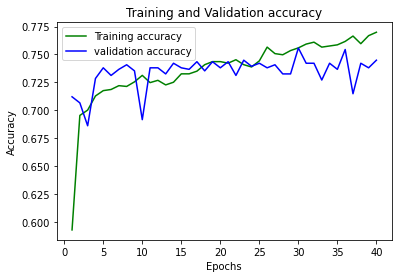

In [40]:
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()